<a href="https://colab.research.google.com/github/yinhang945/CUS635/blob/main/Assignment_3_Medical_Question_Classification_using_DNN_on_PubMed_Encodings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import os
import re
import random
from ast import literal_eval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import gensim
from gensim.models.word2vec import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint


In [148]:
# Embeddings Info. We will use the Word2Vec embeddings created in 06a - 02 Notebook
emb_file1 = './embeddings/The_Avengers_pubmed_w2v_uncased_1024_2_cbow.emb'
emb_file2 = './embeddings/The_Avengers_pubmed_w2v_uncased_1024_2_skip.emb'
emb_file3 = './embeddings/The_Avengers_pubmed_w2v_uncased_1024_5_cbow.emb'
emb_file4 = './embeddings/The_Avengers_pubmed_w2v_uncased_1024_5_skip.emb'
emb_file5 = './embeddings/The_Avengers_pubmed_w2v_uncased_1024_10_cbow.emb'
emb_file6 = './embeddings/The_Avengers_pubmed_w2v_uncased_1024_10_skip.emb'
emb_file7 = './embeddings/The_Avengers_pubmed_w2v_uncased_1024_20_cbow.emb'
emb_file8 = './embeddings/The_Avengers_pubmed_w2v_uncased_1024_20_skip.emb'

# Model Output Folder
model_dir = './models'

# Checkpoint Folder
check_dir = './models/checkpoints'

# Padding/Truncating strategy:
#   'pre': padding or truncate at the beginning of sentence. We assume most valuable information at the end.
#   'post': padding or truncate at the end of the sentence. We assume most valuable information at the beginning.
pad_strategy='pre'

# NN Hyperparameters
epochs = 15
batch_size = 64

# Vector-space embedding hyperparameter
n_dim = 1024
n_unique_words = 15000 # We can use it in place of <vocabulary_size> to reduce the size of the embedding layer.

# NN architecture. A dropout of 0.5 is quite standard
n_dense = 1024
dropout = 0.5

## Loading the Embedding


In [309]:
# Loading embedding if you saved it as a model
# w2v_emb = Word2Vec.load(emb_file)

# Loading embedding if you saved just the weights usng the `save_word2vec_format`
# Set the binary flag accordingly
from gensim.models import KeyedVectors
# w2v_emb1 = KeyedVectors.load_word2vec_format(emb_file1, binary=False)
# w2v_emb1 = KeyedVectors.load_word2vec_format(emb_file2, binary=False)
# w2v_emb1 = KeyedVectors.load_word2vec_format(emb_file3, binary=False)
# w2v_emb1 = KeyedVectors.load_word2vec_format(emb_file4, binary=False)
# w2v_emb1 = KeyedVectors.load_word2vec_format(emb_file5, binary=False)
# w2v_emb1 = KeyedVectors.load_word2vec_format(emb_file6, binary=False)
# w2v_emb1 = KeyedVectors.load_word2vec_format(emb_file7, binary=False)
w2v_emb1 = KeyedVectors.load_word2vec_format(emb_file8, binary=False)

# Pre-Processing
Tokenize the field and generate training and testing splits.

In [150]:
from sklearn.model_selection import train_test_split

data_file = './med_questions.csv'
df = pd.read_csv(data_file)
df.Category = pd.Categorical(df.Category)
df['label'] = df.Category.cat.codes

In [122]:
import nltk
nltk.download('punkt')
tokenized_questions = [word_tokenize(q.lower()) for q in df.Question.tolist()]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [151]:
df['tokens'] = tokenized_questions

In [152]:
train, test = train_test_split(df, test_size=0.2,random_state=1)
print(len(train),len(test))

12312 3079


In [125]:
train.head()

,Category,Question,label,tokens
98,12_MPlusHerbsSupplements_Q,what is rose hip ?,2,"[what, is, rose, hip, ?]"
13048,10_MPlus_ADAM_Q,what causes blepharitis ?,0,"[what, causes, blepharitis, ?]"
10785,10_MPlus_ADAM_Q,what causes asthma ?,0,"[what, causes, asthma, ?]"
11343,5_NIDDK_Q,what causes prostate enlargement: benign prost...,7,"[what, causes, prostate, enlargement, :, benig..."
7285,11_MPlusDrugs_Q,who should get difluprednate ophthalmic and wh...,1,"[who, should, get, difluprednate, ophthalmic, ..."


In [153]:
# Utility Dictionaries
label_to_cat = dict(zip(df['Category'],df['label']))
cat_to_label = dict(zip(df['label'],df['Category']))

## Generate the Space Vectors for a Token-Based Embeddings
This is the process for using a token based embeddings; use the **Generate NERs** process when using an NERs-based embeddings.  
  
  **NOTE:** See this process in the 05 - KNN Classification using Request Encodings.

In [154]:
corpus = train['tokens'].tolist()
corpus_val = test['tokens'].tolist()

## Create dictionary of indexed words including PAD, START, and UNK

In [310]:
word_dict={}
word_dict["_PAD_"] = 0
word_dict["_START_"] = 1
word_dict["_UNK_"] = 2

idx = 3
for word in w2v_emb1.vocab.keys():
    word_dict[word] = idx
    idx+=1

In [311]:
# Decoder used to decode encoded string
word_decoder = {}
for key in word_dict.keys():
    word_decoder[word_dict[key]] = key

In [312]:
# We are including in the vocabulary size the three special strings
vocabulary_size = len(word_dict.keys())
print('Vocabulary Size:', vocabulary_size)

Vocabulary Size: 74999


In [192]:
def get_W(embedding, word_dict):
    vocabulary_size = len(word_dict.keys())
    W = np.zeros((vocabulary_size, n_dim))
    
    for key in word_dict.keys():
        if key == '_PAD_' or key =='_START_':
            embedding_vector = pad_vector
        elif key == '_UNK_':
            embedding_vector = unk_vector
        else:
            embedding_vector = embedding[key]
        W[word_dict[key]] = embedding_vector
    return W

In [313]:
# Many embeddings use the average of all vectors to represent unknown words.
# This is because having a real vector in the embedding space is considered better than a zero-vector
pad_vector = list(np.zeros(n_dim,dtype=int))
unk_vector = list(np.mean(w2v_emb1.vectors, axis=0))
print(pad_vector)
print(unk_vector)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [314]:
W = get_W(w2v_emb1, word_dict)
print(W.shape)

(74999, 1024)


Turning categories string into numerical categories and generate the mapping we can use for the testing dataframe.

In [169]:
def get_quartile_statistics(sentences):
    len_vector = []
    for sentence in sentences:
        len_vector.append(len(sentence))
    
    median_value = np.median(len_vector)
    mean_value = np.mean(len_vector)
    
    max_value = np.max(len_vector)
    min_value = np.min(len_vector)
    return min_value, int(mean_value), int(median_value), max_value
    
def encode_sentences(ltext, word_dictionary, max_length=100, pad_strategy='pre'):
    result = []
    for text in ltext:
        result.append(encode_sentence(text, word_dictionary, max_length, pad_strategy))
    return result
    
def encode_sentence(text, word_dictionary, max_length=100, pad_strategy='pre'):
    result = []
    padding= []
    
    words = text
    wlength = len(words)
    
    if wlength<=max_length:
        padding = list(np.zeros(max_length-wlength,dtype=int))
        if pad_strategy == 'pre':
            result.extend(padding)
    else:
        if pad_strategy == 'pre':
            words = words[0:max_length]
        else:
            words = words[-max_length:]
    
    for word in words:
        try:
            result.append(word_dictionary[word])
        except KeyError:
            result.append(word_dictionary['_UNK_'])
    if pad_strategy == 'post':
        result.extend(padding)
        
    return result

def disp_encoded_sentence(ecodes, word_dictionary):
    result = []
    for val in ecodes:
        result.append(word_decoder[val])
    return result


In [315]:
# Understanding the input size
# Generate a sample to avoid processing the entire dataset
sample = random.sample(corpus, 1000)
len_min, len_avg, len_med, len_max = get_quartile_statistics(corpus)
print('%s - %s/%s - %s' % (len_min, len_avg, len_med, len_max))


4 - 9/9 - 34


In [218]:
corpus[3]

['what',
 'causes',
 'prostate',
 'enlargement',
 ':',
 'benign',
 'prostatic',
 'hyperplasia',
 '?']

In [316]:
max_request_length = 20
pad_strategy = trunc_strategy = 'post'
request = corpus[3]
prequest = encode_sentence(request, word_dict, max_request_length, pad_strategy)

print('Original:', request)
print('Length:', len(prequest))
print()
print('Encoded:', prequest)
print()
print('Reverse Encoding:', disp_encoded_sentence(prequest, word_dict))

Original: ['what', 'causes', 'prostate', 'enlargement', ':', 'benign', 'prostatic', 'hyperplasia', '?']
Length: 20

Encoded: [5722, 2, 1105, 4539, 2, 1421, 3362, 2651, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Reverse Encoding: ['what', '_UNK_', 'prostate', 'enlargement', '_UNK_', 'benign', 'prostatic', 'hyperplasia', '_UNK_', '_PAD_', '_PAD_', '_PAD_', '_PAD_', '_PAD_', '_PAD_', '_PAD_', '_PAD_', '_PAD_', '_PAD_', '_PAD_']


In [317]:
padded_requests = encode_sentences(corpus, word_dict, max_request_length, pad_strategy)

## Generating Training & Validation datasets

In [318]:
padded_df = pd.DataFrame()
padded_df['requests'] = corpus
padded_df['encoded'] = padded_requests
padded_df['label'] = train['label'].tolist()
n_labels = len(set(train['label'].tolist()))

## Generate one-hot encoding of the categories
Generating one-hot encding of the categories will match the output for the softmax output layer

In [319]:
x_train = np.array(padded_df['encoded'].tolist())
y_train = np.array(to_categorical(padded_df['label'].tolist()))

In [223]:
print(type(x_train))
print(type(y_train))
print(x_train.shape)
print(y_train.shape)
print(W.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(12312, 20)
(12312, 12)
(74999, 1024)


### Create Testing Dataset

In [320]:
padded_requests = encode_sentences(corpus_val, word_dict, max_request_length, pad_strategy)
padded_test_df = pd.DataFrame()
padded_test_df['requests'] = corpus_val
padded_test_df['encoded'] = padded_requests
padded_test_df['label'] = test['label'].tolist()

x_test = np.array(padded_test_df['encoded'].tolist())
y_test = np.array(to_categorical(padded_test_df['label'].tolist()))

In [225]:
print(type(x_test))
print(type(y_test))
print(x_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3079, 20)
(3079, 12)


# Architecting the DNN


## Running some initial test
Let's have an ideal on how the DNN learns

In [330]:
epochs = 15
batch_size = 128
n_dense = 1024
dropout = 0.5

dnn = Sequential()
dnn.add(Embedding(vocabulary_size, n_dim, weights=[W], input_length=max_request_length, trainable=False))
dnn.add(Flatten())
dnn.add(Dense(n_dense, activation='relu'))
dnn.add(Dropout(dropout))
dnn.add(Dense(n_labels, activation='softmax'))

In [331]:
dnn.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = dnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Epoch 1/15
97/97 [==============================] - 46s 461ms/step - loss: 0.8563 - accuracy: 0.7092 - val_loss: 0.6618 - val_accuracy: 0.7590
Epoch 2/15
97/97 [==============================] - 44s 458ms/step - loss: 0.5105 - accuracy: 0.8201 - val_loss: 0.5795 - val_accuracy: 0.8042
Epoch 3/15
97/97 [==============================] - 45s 459ms/step - loss: 0.4296 - accuracy: 0.8474 - val_loss: 0.5319 - val_accuracy: 0.8282
Epoch 4/15
97/97 [==============================] - 44s 457ms/step - loss: 0.3821 - accuracy: 0.8633 - val_loss: 0.5807 - val_accuracy: 0.8071
Epoch 5/15
97/97 [==============================] - 44s 455ms/step - loss: 0.3552 - accuracy: 0.8742 - val_loss: 0.5119 - val_accuracy: 0.8243
Epoch 6/15
97/97 [==============================] - 44s 458ms/step - loss: 0.3326 - accuracy: 0.8808 - val_loss: 0.4886 - val_accuracy: 0.8233
Epoch 7/15
97/97 [==============================] - 44s 457ms/step - loss: 0.3151 - accuracy: 0.8882 - val_loss: 0.5081 - val_accuracy: 0.8305

It seems the DNN is learning quite well and achieves a *val_loss* minimum at 0.8376 (in our execution) with a *val_accuracy* of 0.75.

## Run with Checkpoints to Save the Best Model
Let's run the same, but with checkpoints so we can retrieve the best model later.

In [321]:
dnn = Sequential()
dnn.add(Embedding(vocabulary_size, n_dim, embeddings_initializer="uniform", 
                  weights=[W], input_length=max_request_length, trainable=False))
dnn.add(Flatten())
dnn.add(Dense(n_dense, activation='relu'))
dnn.add(Dropout(dropout))
dnn.add(Dense(n_labels, activation='softmax'))

dnn.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
model_checkpoint = ModelCheckpoint(filepath=check_dir+"/weights.{epoch:02d}.hdf5")

In [322]:
dnn.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 20, 1024)          76798976  
                                                                 
 flatten_26 (Flatten)        (None, 20480)             0         
                                                                 
 dense_52 (Dense)            (None, 1024)              20972544  
                                                                 
 dropout_33 (Dropout)        (None, 1024)              0         
                                                                 
 dense_53 (Dense)            (None, 12)                12300     
                                                                 
Total params: 97,783,820
Trainable params: 20,984,844
Non-trainable params: 76,798,976
_________________________________________________________________


In [205]:
print('Embeddings: ',(n_dim, vocabulary_size, n_dim*vocabulary_size))
print('Flatten:', (max_request_length, n_dim, n_dim*max_request_length))
print('Dense:',(n_dense, n_dim*max_request_length*n_dense+n_dense))
print('Output:',(n_dense+1))

Embeddings:  (1024, 74999, 76798976)
Flatten: (20, 1024, 20480)
Dense: (1024, 20972544)
Output: 1025


In [323]:
history = dnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), callbacks=[model_checkpoint])


Epoch 1/15
193/193 [==============================] - 72s 368ms/step - loss: 0.8151 - accuracy: 0.7253 - val_loss: 0.6119 - val_accuracy: 0.7749
Epoch 2/15
193/193 [==============================] - 76s 391ms/step - loss: 0.5242 - accuracy: 0.8144 - val_loss: 0.5448 - val_accuracy: 0.7983
Epoch 3/15
193/193 [==============================] - 71s 370ms/step - loss: 0.4350 - accuracy: 0.8451 - val_loss: 0.5088 - val_accuracy: 0.8146
Epoch 4/15
193/193 [==============================] - 71s 368ms/step - loss: 0.3983 - accuracy: 0.8587 - val_loss: 0.4876 - val_accuracy: 0.8269
Epoch 5/15
193/193 [==============================] - 72s 375ms/step - loss: 0.3653 - accuracy: 0.8686 - val_loss: 0.4675 - val_accuracy: 0.8357
Epoch 6/15
193/193 [==============================] - 71s 370ms/step - loss: 0.3405 - accuracy: 0.8789 - val_loss: 0.4758 - val_accuracy: 0.8298
Epoch 7/15
193/193 [==============================] - 71s 369ms/step - loss: 0.3277 - accuracy: 0.8828 - val_loss: 0.4601 - val_ac

In my case (which can be different at different runs) the best model is the 9th ***weights.09.hdf5***. This can be reloaded at any time.

In [324]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

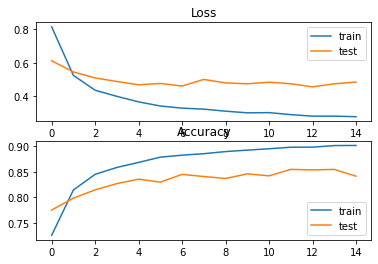

In [325]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Quite good learning graphs.

# Evaluating on the Testing set
We need to validate the performance on the testing set.

In [185]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [326]:
# Load the model from the checkpoint
best_model = Sequential()
best_model.add(Embedding(vocabulary_size, n_dim, embeddings_initializer="uniform", 
                  weights=[W], input_length=max_request_length, trainable=False))
best_model.add(Flatten())
best_model.add(Dense(n_dense, activation='relu'))
best_model.add(Dropout(dropout))
best_model.add(Dense(n_labels, activation='softmax'))

best_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
best_model_path = './models/checkpoints/weights.13.hdf5'
best_model.load_weights(best_model_path)

In [327]:
print("Evaluate model on test data")
# evaluate the model
loss, accuracy, f1_score, precision, recall = best_model.evaluate(x_test, y_test, verbose=0)
print("loss:%s, accuracy: %s, f1:%s, precision:%s, recall:%s" % (loss,accuracy,f1_score,precision,recall))

Evaluate model on test data
loss:0.45519697666168213, accuracy: 0.8538486361503601, f1:0.8538663387298584, precision:0.8934028148651123, recall:0.8186211585998535


In [55]:
results = best_model.predict(x_test)
predictions = []
labels = []

for r in results:
    olist = list(r)
    max_value = max(olist)
    max_index = olist.index(max_value)
    predictions.append(max_index)

for r in y_test:
    olist = list(r)
    max_value = max(olist)
    max_index = olist.index(max_value)
    labels.append(max_index)
    

In [56]:
label_count = test.groupby('label').size().tolist()
correct = {}
for i in range(0,n_labels):
    ccount = 0
    for j in range(0, len(predictions)):
        if predictions[j] == i and labels[j] == i: 
            ccount += 1
    correct[i] = ccount/label_count[i]


In [57]:
threshold = 0.7
good_cat = []

for i in range(n_labels):
    acc = correct[i]
    if acc<threshold:
        print('X %s [Size: %s] [Accuracy: %5.2f]' % (i, str(label_count[i]).rjust(4,' '), acc))
    else:
        print('✓ %s [Size: %s] [Accuracy: %5.2f]' % (i, str(label_count[i]).rjust(4,' '), acc))
        good_cat.append(i)

print()    
print('Performing Categories:')
for c in good_cat:
    print('   '+str(c))

✓ 0 [Size:  416] [Accuracy:  0.78]
✓ 1 [Size:  971] [Accuracy:  1.00]
✓ 2 [Size:  142] [Accuracy:  0.85]
✓ 3 [Size:  122] [Accuracy:  0.85]
X 4 [Size:  210] [Accuracy:  0.36]
✓ 5 [Size:  533] [Accuracy:  0.93]
X 6 [Size:   88] [Accuracy:  0.36]
X 7 [Size:  165] [Accuracy:  0.62]
X 8 [Size:  226] [Accuracy:  0.65]
X 9 [Size:   52] [Accuracy:  0.40]
X 10 [Size:  104] [Accuracy:  0.55]
✓ 11 [Size:   50] [Accuracy:  0.80]

Performing Categories:
   0
   1
   2
   3
   5
   11


## Saving the Model

In [ ]:
best_model.save('../models/dnn.h5')

## Final Summary Table



| Embedding Name | Accuracy | F1-Score |
| --- | --- | --- |
| The_Avengers_pubmed_w2v_uncased_1024_2_cbow.emb | 0.8213706017 | 0.8249465823 |
| The_Avengers_pubmed_w2v_uncased_1024_2_skip.emb | 0.8376095891 | 0.8396823406 |
| The_Avengers_pubmed_w2v_uncased_1024_5_cbow.emb | 0.8109775782 | 0.8171428442 |
| The_Avengers_pubmed_w2v_uncased_1024_5_skip.emb | 0.8499512672 | 0.8530312181 |
| The_Avengers_pubmed_w2v_uncased_1024_10_cbow.emb | 0.8145501614 | 0.8254490495 |
| The_Avengers_pubmed_w2v_uncased_1024_10_skip.emb | 0.8447548151 | 0.8482908012 |
| The_Avengers_pubmed_w2v_uncased_1024_20_cbow.emb | 0.8229944706 | 0.8287500739 |
| The_Avengers_pubmed_w2v_uncased_1024_20_skip.emb | 0.8538486362 | 0.8538663387 |